<a href="https://colab.research.google.com/github/Ogweno/portfolio/blob/main/Fraud_Detection_PySpark_hypertuned.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import subprocess
from tqdm import tqdm

# List of libraries to install
libraries = ['pyspark', \
             '--packages com.databricks:spark-csv_2.10:1.2.0',\
             'ppscore',\
             'findspark',\
             'rpy2',\
             'sparkxgb', \
             'lightgbm', \
             'catboost',\
             '--upgrade --force-reinstall --no-deps kaggle',\
             '--upgrade xgboost-spark']

# Install libraries in silence
#for lib in tqdm(libraries, desc="Installing libraries", unit="library"):
#    os.system(f"pip install {lib} -q")
for lib in tqdm(libraries, desc="Installing Libraries"):
    subprocess.run(['pip', 'install', '--quiet', lib])

#os.kill(os.getpid(), 9)

Installing Libraries: 100%|██████████| 10/10 [02:35<00:00, 15.59s/it]


In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [3]:
!mkdir -p ~/.kaggle
!cp /content/drive/MyDrive/Kaggle/kaggle.json ~/.kaggle/kaggle.json

#!cp /content/drive/MyDrive/Kaggle/kaggle.json /root/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
from pyspark.sql import SparkSession
spark = SparkSession.builder\
        .master("local")\
        .appName("Fraud Detection Using pyspark and hypertuned params ")\
        .config('spark.ui.port', '4050')\
        .config("spark.executor.memory", "8g") \
        .getOrCreate()

In [5]:
import pandas as pd
import seaborn as sns
import missingno as msno
import numpy as np
import matplotlib.pyplot as plt
from tabulate import tabulate
import pyspark.sql.functions as F
from pyspark.sql.functions import countDistinct
from pyspark.sql.functions import mean, stddev, format_number, col, countDistinct
from py4j.protocol import Py4JJavaError

from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder, CrossValidatorModel

from pyspark.ml import Pipeline
from pyspark.ml.feature import MinMaxScaler
from pyspark.mllib.util import MLUtils

from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.evaluation import BinaryClassificationEvaluator

from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.sql.types import FloatType
from pyspark.mllib.evaluation import BinaryClassificationMetrics

from pyspark.ml.classification import RandomForestClassifier, MultilayerPerceptronClassifier
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.classification import LinearSVC, OneVsRest
from pyspark.ml.classification import NaiveBayes
#from pyspark.ml.classification import XGBoostClassifier

from sparkxgb import XGBoostClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier

from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from sklearn.metrics import roc_curve,roc_auc_score, auc, precision_recall_curve, log_loss, mean_squared_error, mean_absolute_error, matthews_corrcoef, cohen_kappa_score

import rpy2.robjects as robjects
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri

In [6]:
! kaggle datasets download mlg-ulb/creditcardfraud

 92% 61.0M/66.0M [00:00<00:00, 87.2MB/s]
100% 66.0M/66.0M [00:00<00:00, 69.6MB/s]


In [7]:
! unzip creditcardfraud.zip

Archive:  creditcardfraud.zip
  inflating: creditcard.csv          


In [8]:
df = spark.read.csv('/content/creditcard.csv',header=True,inferSchema=True)
df.show(2)

+----+----------------+-------------------+----------------+-----------------+------------------+-------------------+-------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+-----------------+------------------+------------------+------------------+------------------+-------------------+------------------+------------------+------------------+------------------+-----------------+------------------+--------------------+-------------------+------+-----+
|Time|              V1|                 V2|              V3|               V4|                V5|                 V6|                 V7|                V8|                V9|               V10|               V11|               V12|               V13|               V14|              V15|               V16|               V17|               V18|               V19|                V20|               V21|               V22|               V23|       

In [9]:
def balance_classes(dataframe, class_column='Class', sample_size=None, random_state=None):
    # Convert PySpark DataFrame to Pandas DataFrame
    data = dataframe.toPandas()

    # Shuffle the DataFrame
    data = data.sample(frac=1, random_state=random_state)

    # Determine the sample size
    if sample_size is None:
        sample_size = min(data[class_column].value_counts())

    # Extract fraud and non-fraud classes
    fraud_df = data.loc[data[class_column] == 1]
    non_fraud_df = data.loc[data[class_column] == 0][:sample_size]

    # Concatenate fraud and non-fraud classes
    balanced_df = pd.concat([fraud_df, non_fraud_df])

    # Shuffle the balanced DataFrame
    balanced_df = balanced_df.sample(frac=1, random_state=random_state)

    return balanced_df

def plot_class_distribution(dataframe, class_column='Class'):
    # Print class distribution
    print('Distribution of the Classes in the subsample dataset:')
    print(dataframe[class_column].value_counts() / len(dataframe))

    # Plot class distribution
    plt.figure(figsize=(5, 4))
    sns.countplot(x=class_column, data=dataframe)  # Specify 'x' parameter explicitly
    plt.title('Equally Distributed Classes', fontsize=14)
    plt.savefig('Figures_fraud/Fraud_dist_sampled.jpg')
    plt.show()

In [10]:
'''Check if directory exists, if not, create it'''
import os
# You should change 'images' to your preferred folder.
MYDIR = ("Figures_fraud")
CHECK_FOLDER = os.path.isdir(MYDIR)

# If folder doesn't exist, then create it.
if not CHECK_FOLDER:
    os.makedirs(MYDIR)
    print("created folder : ", MYDIR)

else:
    print(MYDIR, "folder already exists.")

created folder :  Figures_fraud


Distribution of the Classes in the subsample dataset:
1    0.5
0    0.5
Name: Class, dtype: float64


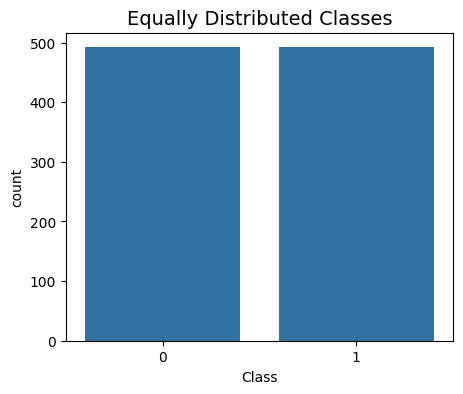

In [11]:
# Assuming 'df' is your DataFrame
balanced_df = balance_classes(df)
plot_class_distribution(balanced_df)

In [12]:
def plot_violin(df, column):
    """
    Generate a violin plot for a specified column in a PySpark DataFrame.

    Parameters:
        df (DataFrame): PySpark DataFrame containing the data.
        column (str): Name of the column to plot.

    Returns:
        None
    """
    # Extract data from the specified column
    data = df.select(column).toPandas()

    # Plot the violin plot
    plt.figure(figsize=(10, 5))
    sns.violinplot(data=data, x=column)
    plt.title(f'Violin Plot for {column}')
    plt.show()

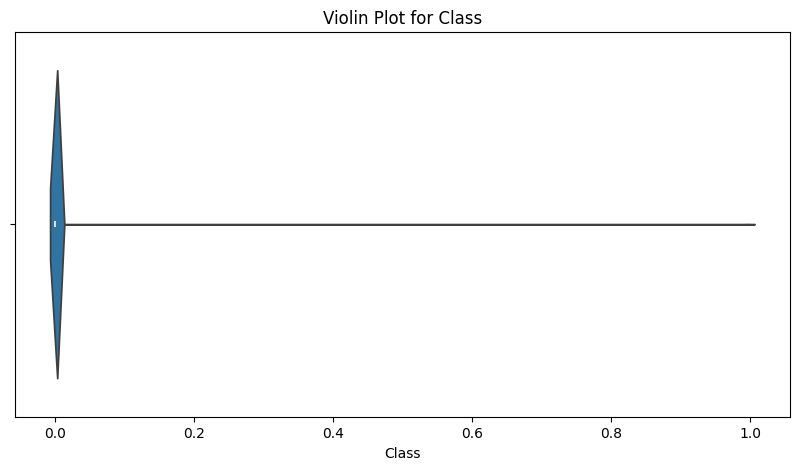

In [13]:
plot_violin(df, 'Class')

In [14]:
def scale_and_remove_columns(dataframe, input_col="Amount", output_col="SAmount", drop_cols=["Amount", "Amount_Vect", "Time"]):
    # Step 1: Make Vector of the Values in Amount Column
    assembler = VectorAssembler(inputCols=[input_col], outputCol="Amount_Vect")
    output = assembler.transform(dataframe)
    output.show(5)

    # Step 2: Apply Scaling on it
    scaler = StandardScaler(inputCol="Amount_Vect", outputCol=output_col, withStd=True, withMean=False)
    final_df = scaler.fit(output).transform(output)
    final_df.show(5)

    # Step 3: Remove unwanted columns
    final_df = final_df.drop(*drop_cols)
    final_df.show(5)

    return final_df

# Convert Pandas DataFrame to PySpark DataFrame
balanced_spark_df = spark.createDataFrame(balanced_df)

# Call the function with the PySpark DataFrame
scaled_removed_df = scale_and_remove_columns(balanced_spark_df)

/usr/local/lib/python3.10/dist-packages/pyspark/sql/pandas/conversion.py:331: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column, series in pdf.iteritems():


+--------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+-----------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+-----------------+-------------------+-------------------+--------------------+------+-----+-----------+
|    Time|                V1|                V2|                V3|                V4|                V5|                V6|                V7|                V8|                V9|               V10|               V11|               V12|               V13|              V14|               V15|               V16|               V17|               V18|               V19|               V20|               V21|               V22|   

In [15]:
def prepare_features(dataframe, numericCols, binaryCol):
    # Exclude the binary column from the numeric columns
    numericCols = [col for col in numericCols if col != binaryCol]

    # VectorAssembler to combine numeric features into a single vector
    assembler = VectorAssembler(inputCols=numericCols, outputCol="features")
    output = assembler.transform(dataframe)

    # Select only the features and the binary column
    selectedCols = ["features", binaryCol]
    return output.select(selectedCols)


selectedNumericCols = ['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28']
binaryCol = 'Class'

# Convert Pandas DataFrame to PySpark DataFrame
balanced_spark_df = spark.createDataFrame(balanced_df)

mdf = prepare_features(balanced_spark_df, selectedNumericCols, binaryCol)
mdf.show(5)

+--------------------+-----+
|            features|Class|
+--------------------+-----+
|[-0.3563261540903...|    1|
|[1.11649329682733...|    0|
|[1.22372354945189...|    0|
|[1.42845269919591...|    0|
|[-2.3682857901735...|    0|
+--------------------+-----+
only showing top 5 rows



In [16]:
def prepare_features(dataframe, numericCols, targetCol):
    from pyspark.ml.feature import VectorAssembler, StandardScaler
    from pyspark.sql.functions import col

    # Assemble the numeric columns into a features vector
    assembler = VectorAssembler(inputCols=numericCols, outputCol="features")
    mdf = assembler.transform(dataframe)

    # Check if the output column exists
    if "features" in mdf.columns:
        # Scale numeric features between -1 and 1
        if "scaled_features" in mdf.columns:
            # Drop the existing scaled_features column
            mdf = mdf.drop("scaled_features")

        scaler = StandardScaler(inputCol="features", outputCol="scaled_features", withStd=True, withMean=False)
        scaler_model = scaler.fit(mdf)
        mdf = scaler_model.transform(mdf)
    else:
        raise ValueError("Column 'features' not found in dataframe.")

    # Rename the target column
    mdf = mdf.withColumnRenamed(targetCol, "label")

    return mdf.randomSplit([0.7, 0.3], seed=2018)



In [17]:
# Assuming selectedNumericCols is defined
selectedNumericCols = ['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28']
targetCol = "Class"

balanced_spark_df = spark.createDataFrame(balanced_df)

# Call the prepare_features function
mdf = prepare_features(balanced_spark_df, selectedNumericCols, targetCol)


In [18]:
len(selectedNumericCols)

28

In [19]:
# Get column names from the first DataFrame inside the tuple
column_names = mdf[0].columns

# Print the column names
print(column_names)

['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount', 'label', 'features', 'scaled_features']


In [19]:
# Number of classes in your data
num_classes = 2  # For binary classification

In [20]:
# Assuming `mdf` is a PySpark DataFrame
input_cols = mdf[0].columns  # Get the input columns of the DataFrame

# Define the layers for MultilayerPerceptronClassifier
layers = [len(input_cols), 30, 20, 2]

In [21]:
# Define classifiers with input layers from selectedNumericCols
classifiers = [
    LogisticRegression(featuresCol='features', labelCol='label', maxIter=2, regParam=0.0, elasticNetParam=0.0),
    RandomForestClassifier(featuresCol='features', labelCol='label', numTrees=100),
    GBTClassifier(featuresCol='features', labelCol='label', maxIter=10),
    DecisionTreeClassifier(featuresCol='features', labelCol='label'),
    #MultilayerPerceptronClassifier(featuresCol='features', labelCol='label', layers=[len(column_names), 30, 20, 2]),
    #NaiveBayes(featuresCol='features', labelCol='label', smoothing=1.0, modelType="multinomial"),
    LinearSVC(featuresCol='features', labelCol='label', maxIter=100)
    #LGBMClassifier(featuresCol='features', labelCol='label'),  # Add LGBMClassifier
    #CatBoostClassifier(iterations=10, depth=8, learning_rate=0.1, loss_function='Logloss', verbose=True),  # Add CatBoostClassifier
    #XGBClassifier(max_depth=8, learning_rate=0.1, n_estimators=100)  # Add XGBClassifier
]

In [22]:
# Define parameter grids for each classifier
param_grids = [
    ParamGridBuilder()
        .addGrid(LogisticRegression.regParam, [0.05, 0.15])
        .addGrid(LogisticRegression.elasticNetParam, [0.25, 0.75])
        .addGrid(LogisticRegression.maxIter, [5, 10])
        .addGrid(LogisticRegression.tol, [1e-4, 1e-5])
        .build(),

    ParamGridBuilder().build(),  # No hyperparameters to tune for RandomForestClassifier

    ParamGridBuilder()
        .addGrid(GBTClassifier.maxIter, [10])
        .addGrid(GBTClassifier.maxDepth, [6, 7, 10])
        .build(),

    ParamGridBuilder().build(),  # No hyperparameters to tune for DecisionTreeClassifier

    ParamGridBuilder().build(),  # No hyperparameters to tune for MultilayerPerceptronClassifier

    ParamGridBuilder().build(),  # No hyperparameters to tune for NaiveBayes

    ParamGridBuilder().build(),  # No hyperparameters to tune for LinearSVC

    ParamGridBuilder().build(),  # No hyperparameters to tune for LGBMClassifier

    None,  # No hyperparameters to tune for CatBoostClassifier

    {'max_depth': [6, 8, 10], 'learning_rate': [0.1, 0.01]}  # Parameter grid for XGBClassifier
]

classifiers.extend([
    # XGBClassifier(featuresCol='features', labelCol='label'),
    #LGBMClassifier(featuresCol='features', labelCol='label'),
    #CatBoostClassifier(iterations=10, depth=8, learning_rate=0.1, loss_function='Logloss', verbose=True),
    #XGBClassifier(max_depth=8, learning_rate=0.1, n_estimators=100)
])

#param_grids.extend([
#    ParamGridBuilder().build(),  # No hyperparameters to tune for XGBoostClassifier
#    ParamGridBuilder().build(),  # No hyperparameters to tune for LGBMClassifier
#    None,  # No hyperparameters to tune for CatBoostClassifier
#    {'max_depth': [6, 8, 10], 'learning_rate': [0.1, 0.01]}  # Parameter grid for XGBClassifier
#])



In [23]:
# Define a list to store CrossValidator instances for each classifier
cross_validators = []

# Perform hyperparameter tuning and cross-validation for each classifier
for classifier, param_grid in zip(classifiers, param_grids):
    # Prepare features and split data into train and test sets
    train_data, test_data = prepare_features(balanced_spark_df, selectedNumericCols, targetCol)

    # Define the pipeline with classifier
    pipeline = Pipeline(stages=[classifier])

    # Define the evaluator
    evaluator = BinaryClassificationEvaluator(labelCol='label')

    # Check if param_grid exists
    if param_grid:
        # Cross-validation with hyperparameter tuning
        cross_validator = CrossValidator(estimator=pipeline, estimatorParamMaps=param_grid, evaluator=evaluator, numFolds=3)
    else:
        # Cross-validation without hyperparameter tuning
        cross_validator = CrossValidator(estimator=pipeline, evaluator=evaluator, numFolds=3)

    # Append the CrossValidator instance to the list
    cross_validators.append(cross_validator)


print("Training Dataset Count:", train_data.count())
print("Test Dataset Count:", test_data.count())

Training Dataset Count: 704
Test Dataset Count: 280


In [24]:
# Initialize an empty list to store cv_models
cv_models = []

# Perform hyperparameter tuning and cross-validation for each classifier
for i, cv in enumerate(cross_validators):
    print(f"Classifier {i + 1}:")
    cv_model = cv.fit(train_data)  # Fit the cross-validator model
    cv_models.append(cv_model)  # Store the cv_model
    print("Pipeline Stages:")
    for stage in cv_model.bestModel.stages:
        print(stage)

    best_model = cv_model.bestModel
    if hasattr(best_model, 'stages') and best_model.stages[-1]._java_obj.getClass().getSimpleName() != 'CrossValidatorModel':
        print("Best Model Parameters:")
        print(best_model.stages[-1].extractParamMap())
    else:
        print("No best model parameters found.")




Classifier 1:
Pipeline Stages:
LogisticRegressionModel: uid=LogisticRegression_1c2cddeacf9a, numClasses=2, numFeatures=28
Best Model Parameters:
{Param(parent='LogisticRegression_1c2cddeacf9a', name='aggregationDepth', doc='suggested depth for treeAggregate (>= 2).'): 2, Param(parent='LogisticRegression_1c2cddeacf9a', name='elasticNetParam', doc='the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty.'): 0.0, Param(parent='LogisticRegression_1c2cddeacf9a', name='family', doc='The name of family which is a description of the label distribution to be used in the model. Supported options: auto, binomial, multinomial'): 'auto', Param(parent='LogisticRegression_1c2cddeacf9a', name='featuresCol', doc='features column name.'): 'features', Param(parent='LogisticRegression_1c2cddeacf9a', name='fitIntercept', doc='whether to fit an intercept term.'): True, Param(parent='LogisticRegression_1c2cddeacf9a', name='labelCol', d

# Compare all models using various performance metrics

In [33]:
def evaluate_model(model, train, test, model_name, models_metrics):
    # Make predictions on the test data
    predictions = model.transform(test)

    # Evaluate the model's performance
    evaluator_multiclass = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction")
    accuracy = evaluator_multiclass.evaluate(predictions, {evaluator_multiclass.metricName: "accuracy"})

    evaluator_binary = BinaryClassificationEvaluator(labelCol="label")
    auc_score = evaluator_binary.evaluate(predictions)

    # Calculate confusion matrix
    preds_and_labels = predictions.select("prediction", "label").rdd.map(lambda row: (float(row.prediction), float(row.label)))
    metrics = MulticlassMetrics(preds_and_labels)
    cm = metrics.confusionMatrix().toArray()

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt=".0f", cmap="Blues", xticklabels=["Non-Fraud", "Fraud"], yticklabels=["Non-Fraud", "Fraud"])
    plt.title(f'Confusion Matrix - {model_name}')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

    # Plot ROC curve if 'probability' column exists
    if 'probability' in predictions.columns:
        y_test = [row.label for row in predictions.select("label").collect()]
        y_score = [row.probability[1] for row in predictions.select("probability").collect()]
        fpr, tpr, _ = roc_curve(y_test, y_score)
        roc_auc = auc(fpr, tpr)

        # Calculate additional metrics
        precision, recall, f1_score_non_fraud, f1_score_fraud = None, None, None, None
        logloss, mse, mae, mcc, kappa = None, None, None, None, None

        y_score = [row.probability[1] for row in predictions.select("probability").collect()]
        y_test = [row.label for row in predictions.select("label").collect()]
        precision, recall, _ = precision_recall_curve(y_test, y_score)
        logloss = log_loss(y_test, y_score)
        mse = mean_squared_error(y_test, y_score)
        mae = mean_absolute_error(y_test, y_score)
        mcc = matthews_corrcoef(y_test, [1 if val > 0.5 else 0 for val in y_score])
        kappa = cohen_kappa_score(y_test, [1 if val > 0.5 else 0 for val in y_score])
        f1_score_non_fraud = metrics.fMeasure(0.0)
        f1_score_fraud = metrics.fMeasure(1.0)
        fpr, tpr, _ = roc_curve(y_test, y_score)
        roc_auc = auc(fpr, tpr)

        # Store metrics in model_metrics dictionary
        model_metrics = {
            "Accuracy": round(accuracy, 2),
            "AUC": round(auc_score, 2),
            "Precision (Non-Fraud)": round(precision[0], 2) if precision is not None else None,
            "Precision (Fraud)": round(precision[1], 2) if precision is not None else None,
            "Recall (Non-Fraud)": round(recall[0], 2) if recall is not None else None,
            "Recall (Fraud)": round(recall[1], 2) if recall is not None else None,
            "F1-score (Non-Fraud)": round(f1_score_non_fraud, 2) if f1_score_non_fraud is not None else None,
            "F1-score (Fraud)": round(f1_score_fraud, 2) if f1_score_fraud is not None else None,
            "Log Loss": round(logloss, 2) if logloss is not None else None,
            "Mean Squared Error": round(mse, 2) if mse is not None else None,
            "Mean Absolute Error": round(mae, 2) if mae is not None else None,
            "Matthews Correlation Coefficient": round(mcc, 2) if mcc is not None else None,
            "Cohen's Kappa": round(kappa, 2) if kappa is not None else None,
            "fpr": fpr,
            "tpr": tpr,
            "roc_auc": roc_auc,
            "Confusion Matrix": cm  # Include confusion matrix in the metrics dictionary
        }

        # Printing metrics table
        print(f"Metrics for {model_name}:")
        metrics_table = [
            ["Accuracy", round(accuracy, 2)],
            ["AUC", round(auc_score, 2)],
            ["Precision (Non-Fraud)", round(precision[0], 2) if precision is not None else None],
            ["Precision (Fraud)", round(precision[1], 2) if precision is not None else None],
            ["Recall (Non-Fraud)", round(recall[0], 2) if recall is not None else None],
            ["Recall (Fraud)", round(recall[1], 2) if recall is not None else None],
            ["F1-score (Non-Fraud)", round(f1_score_non_fraud, 2) if f1_score_non_fraud is not None else None],
            ["F1-score (Fraud)", round(f1_score_fraud, 2) if f1_score_fraud is not None else None],
            ["Log Loss", round(logloss, 2) if logloss is not None else None],
            ["Mean Squared Error", round(mse, 2) if mse is not None else None],
            ["Mean Absolute Error", round(mae, 2) if mae is not None else None],
            ["Matthews Correlation Coefficient", round(mcc, 2) if mcc is not None else None],
            ["Cohen's Kappa", round(kappa, 2) if kappa is not None else None]
        ]

        print(tabulate(metrics_table, headers=["Metric", "Value"], tablefmt="grid"))

        # Return metrics_table and ROC curve metrics
        return model_metrics
    else:
        # Return an empty dictionary if no metrics are calculated
        return {}


In [26]:
classifier_names = [type(classifier).__name__ for classifier in classifiers]
print(classifier_names)

['LogisticRegression', 'RandomForestClassifier', 'GBTClassifier', 'DecisionTreeClassifier', 'LinearSVC']


In [27]:
# Define the best models obtained from cross-validation
best_models = [
    cv_model.bestModel for cv_model in cv_models
]

# Initialize models_dict to store predictions
models_dict = {}

# Iterate through best_models and classifier_names simultaneously
for model, model_name in zip(best_models, classifier_names):
    print(f"{model_name}:")

    # Make predictions using the best model
    prediction_df = model.transform(test_data)

    # Store predictions in models_dict
    models_dict[model_name] = prediction_df

# Access predictions for each classifier
for model_name, prediction_df in models_dict.items():
    print(f"Predictions for {model_name}:")
    if "probability" in prediction_df.columns:
        prediction_df.select("prediction", "probability").show(5)
    else:
        prediction_df.select("prediction").show(5)




LogisticRegression:
RandomForestClassifier:
GBTClassifier:
DecisionTreeClassifier:
LinearSVC:
Predictions for LogisticRegression:
+----------+--------------------+
|prediction|         probability|
+----------+--------------------+
|       1.0|[0.07647913526103...|
|       0.0|[0.51118796439844...|
|       1.0|[0.00948240016664...|
|       1.0|[0.24249891593839...|
|       1.0|[0.02263964951728...|
+----------+--------------------+
only showing top 5 rows

Predictions for RandomForestClassifier:
+----------+--------------------+
|prediction|         probability|
+----------+--------------------+
|       1.0|[0.00472017973856...|
|       0.0|[0.86153636093695...|
|       1.0|[7.92173409448167...|
|       1.0|[0.06154574075565...|
|       1.0|[0.00132855352233...|
+----------+--------------------+
only showing top 5 rows

Predictions for GBTClassifier:
+----------+--------------------+
|prediction|         probability|
+----------+--------------------+
|       1.0|[0.06606160658309...|
|

In [28]:
model_names = [name.replace("Classifier", "") for name in classifier_names]


LogisticRegression:
RandomForestClassifier:
GBTClassifier:
DecisionTreeClassifier:
LinearSVC:
Predictions for LogisticRegression:
+----------+--------------------+
|prediction|         probability|
+----------+--------------------+
|       1.0|[0.07647913526103...|
|       0.0|[0.51118796439844...|
|       1.0|[0.00948240016664...|
|       1.0|[0.24249891593839...|
|       1.0|[0.02263964951728...|
+----------+--------------------+
only showing top 5 rows



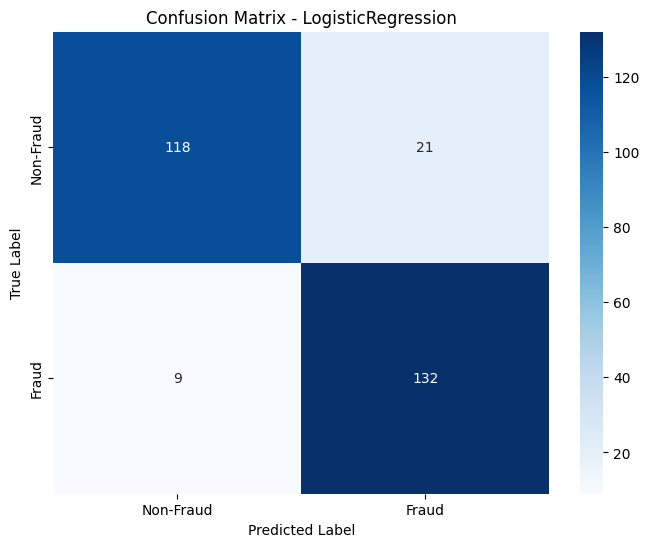

Metrics for LogisticRegression:
+----------------------------------+---------+
| Metric                           |   Value |
+==================================+=========+
| Accuracy                         |    0.89 |
+----------------------------------+---------+
| AUC                              |    0.96 |
+----------------------------------+---------+
| Precision (Non-Fraud)            |    0.5  |
+----------------------------------+---------+
| Precision (Fraud)                |    0.51 |
+----------------------------------+---------+
| Recall (Non-Fraud)               |    1    |
+----------------------------------+---------+
| Recall (Fraud)                   |    1    |
+----------------------------------+---------+
| F1-score (Non-Fraud)             |    0.89 |
+----------------------------------+---------+
| F1-score (Fraud)                 |    0.9  |
+----------------------------------+---------+
| Log Loss                         |    0.37 |
+---------------------------

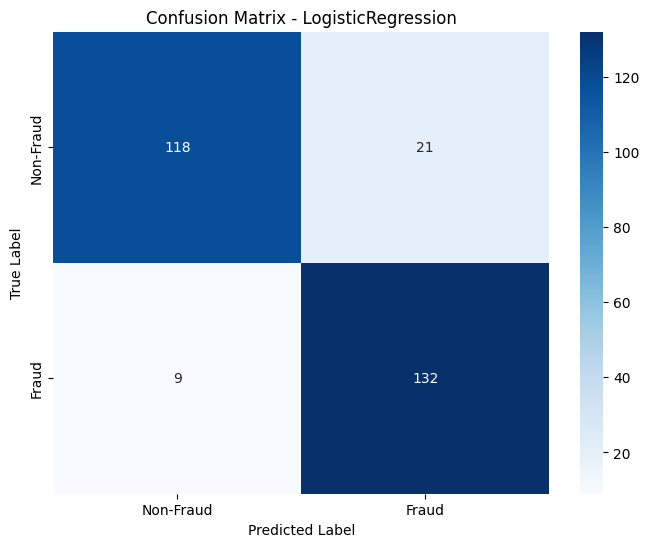

Predictions for RandomForestClassifier:
+----------+--------------------+
|prediction|         probability|
+----------+--------------------+
|       1.0|[0.00472017973856...|
|       0.0|[0.86153636093695...|
|       1.0|[7.92173409448167...|
|       1.0|[0.06154574075565...|
|       1.0|[0.00132855352233...|
+----------+--------------------+
only showing top 5 rows



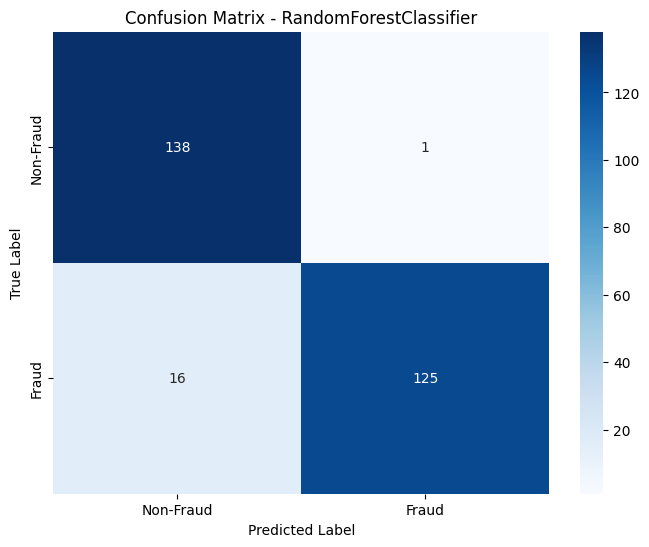

Metrics for RandomForestClassifier:
+----------------------------------+---------+
| Metric                           |   Value |
+==================================+=========+
| Accuracy                         |    0.94 |
+----------------------------------+---------+
| AUC                              |    0.98 |
+----------------------------------+---------+
| Precision (Non-Fraud)            |    0.5  |
+----------------------------------+---------+
| Precision (Fraud)                |    0.51 |
+----------------------------------+---------+
| Recall (Non-Fraud)               |    1    |
+----------------------------------+---------+
| Recall (Fraud)                   |    1    |
+----------------------------------+---------+
| F1-score (Non-Fraud)             |    0.94 |
+----------------------------------+---------+
| F1-score (Fraud)                 |    0.94 |
+----------------------------------+---------+
| Log Loss                         |    0.17 |
+-----------------------

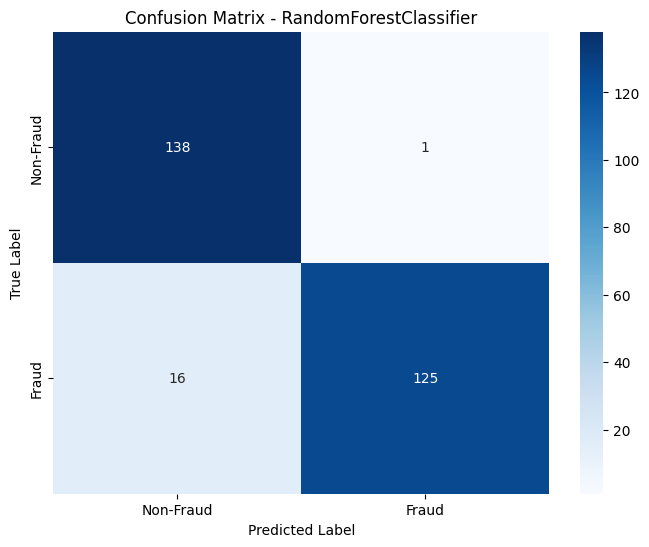

Predictions for GBTClassifier:
+----------+--------------------+
|prediction|         probability|
+----------+--------------------+
|       1.0|[0.06606160658309...|
|       0.0|[0.58825912889842...|
|       1.0|[0.06606160658309...|
|       1.0|[0.06606160658309...|
|       1.0|[0.06606160658309...|
+----------+--------------------+
only showing top 5 rows



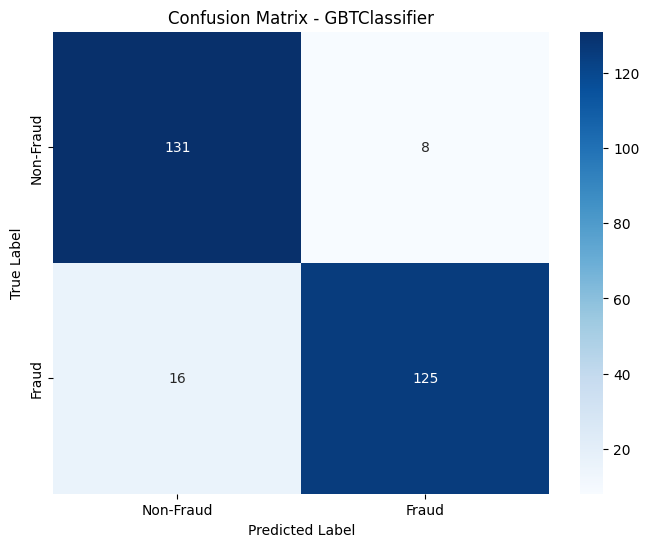

Metrics for GBTClassifier:
+----------------------------------+---------+
| Metric                           |   Value |
+==================================+=========+
| Accuracy                         |    0.91 |
+----------------------------------+---------+
| AUC                              |    0.96 |
+----------------------------------+---------+
| Precision (Non-Fraud)            |    0.5  |
+----------------------------------+---------+
| Precision (Fraud)                |    0.51 |
+----------------------------------+---------+
| Recall (Non-Fraud)               |    1    |
+----------------------------------+---------+
| Recall (Fraud)                   |    1    |
+----------------------------------+---------+
| F1-score (Non-Fraud)             |    0.92 |
+----------------------------------+---------+
| F1-score (Fraud)                 |    0.91 |
+----------------------------------+---------+
| Log Loss                         |    0.26 |
+--------------------------------

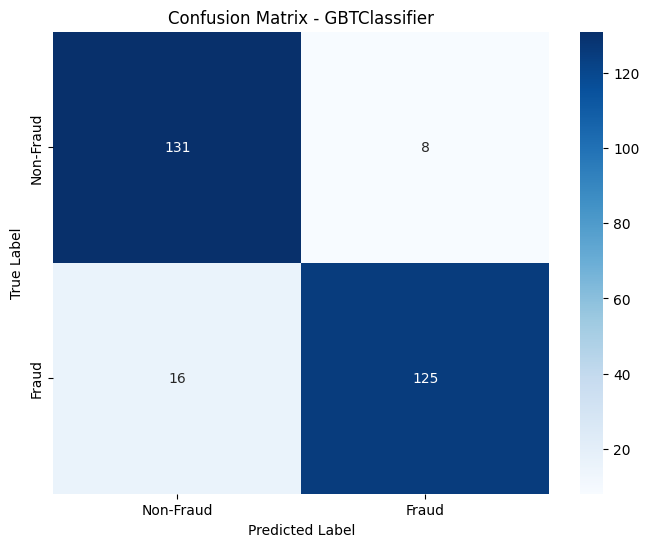

Predictions for DecisionTreeClassifier:
+----------+-----------+
|prediction|probability|
+----------+-----------+
|       1.0|  [0.0,1.0]|
|       1.0|  [0.4,0.6]|
|       1.0|  [0.0,1.0]|
|       1.0|  [0.0,1.0]|
|       1.0|  [0.0,1.0]|
+----------+-----------+
only showing top 5 rows



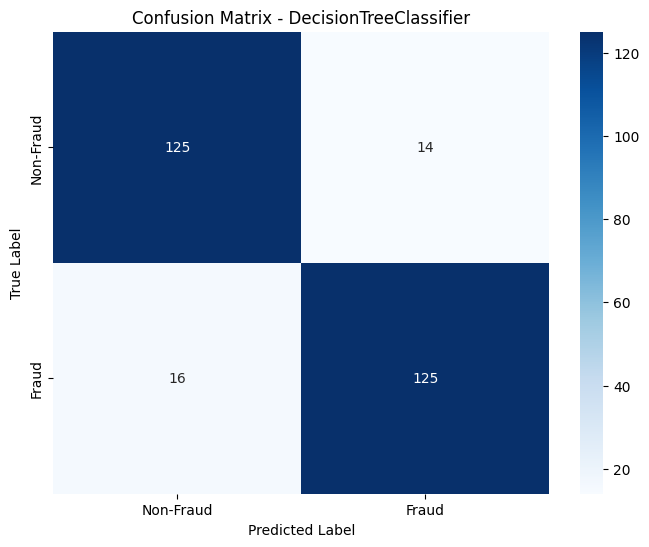

Metrics for DecisionTreeClassifier:
+----------------------------------+---------+
| Metric                           |   Value |
+==================================+=========+
| Accuracy                         |    0.89 |
+----------------------------------+---------+
| AUC                              |    0.88 |
+----------------------------------+---------+
| Precision (Non-Fraud)            |    0.5  |
+----------------------------------+---------+
| Precision (Fraud)                |    0.49 |
+----------------------------------+---------+
| Recall (Non-Fraud)               |    1    |
+----------------------------------+---------+
| Recall (Fraud)                   |    0.96 |
+----------------------------------+---------+
| F1-score (Non-Fraud)             |    0.89 |
+----------------------------------+---------+
| F1-score (Fraud)                 |    0.89 |
+----------------------------------+---------+
| Log Loss                         |    1.59 |
+-----------------------

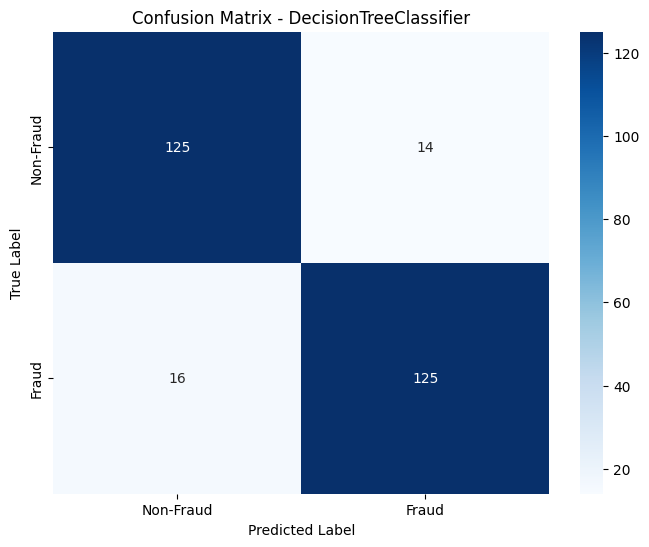

Predictions for LinearSVC:
+----------+
|prediction|
+----------+
|       1.0|
|       0.0|
|       1.0|
|       1.0|
|       1.0|
+----------+
only showing top 5 rows



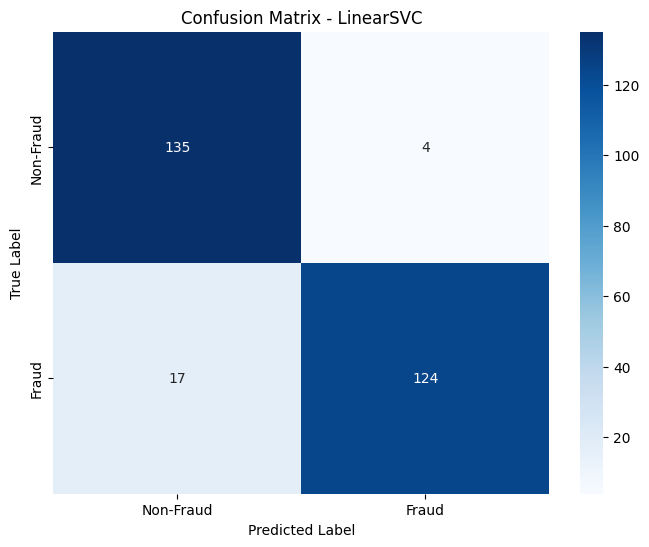

Confusion matrix not available for LinearSVC


In [35]:
# Make predictions for each classifier
predictions = []
model_names = classifier_names  # Store model names
models_metrics = {}

for i, model in enumerate(best_models):
    print(f"{model_names[i]}:")
    # Make predictions using the best model
    prediction_df = model.transform(test_data)
    predictions.append(prediction_df)

# Access predictions for each classifier
for model_name, prediction_df, model in zip(model_names, predictions, best_models):
    print(f"Predictions for {model_name}:")
    if "probability" in prediction_df.columns:
        prediction_df.select("prediction", "probability").show(5)
    else:
        prediction_df.select("prediction").show(5)

    # Evaluate model and store metrics
    model_metrics = evaluate_model(model, train_data, test_data, model_name, models_metrics)

    # Plot confusion matrix
    if "Confusion Matrix" in model_metrics.keys():  # Check if "Confusion Matrix" key exists
        cm = model_metrics["Confusion Matrix"]
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt=".0f", cmap="Blues", xticklabels=["Non-Fraud", "Fraud"], yticklabels=["Non-Fraud", "Fraud"])
        plt.title(f'Confusion Matrix - {model_name}')
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        plt.show()
    else:
        print("Confusion matrix not available for", model_name)

    models_metrics[model_name] = model_metrics



# Boxplots comparing various hypertuned models

Models: ['LogisticRegression', 'RandomForestClassifier', 'GBTClassifier', 'DecisionTreeClassifier', 'LinearSVC']
Metrics: ['Accuracy', 'AUC', 'Precision (Non-Fraud)', 'Precision (Fraud)', 'Recall (Non-Fraud)', 'Recall (Fraud)', 'F1-score (Non-Fraud)', 'F1-score (Fraud)', 'Log Loss', 'Mean Squared Error', 'Mean Absolute Error', 'Matthews Correlation Coefficient', "Cohen's Kappa", 'fpr', 'tpr', 'roc_auc', 'Confusion Matrix']
Generating plot for Accuracy...
Sorted model data for Accuracy: [[0.89], [0.94], [0.91], [0.89]]


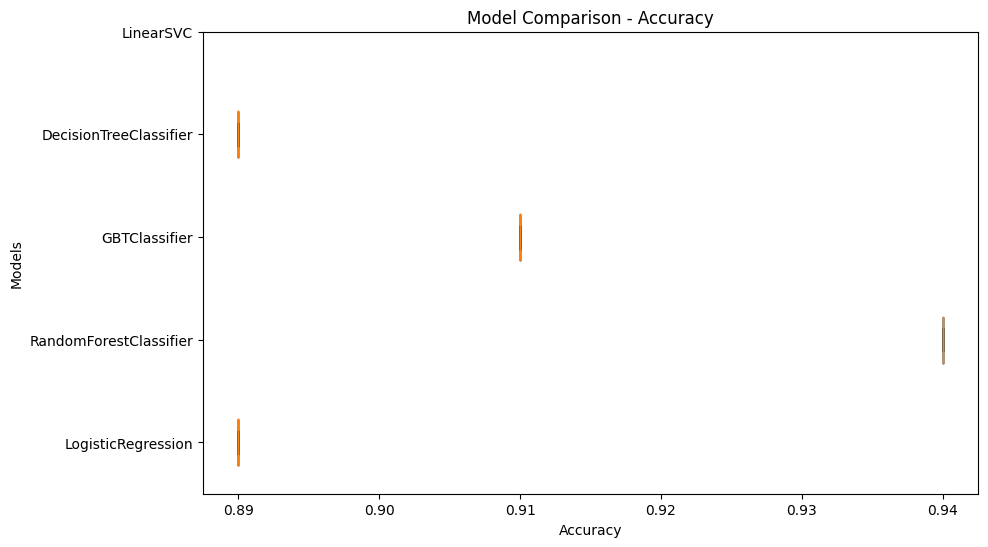

Generating plot for AUC...
Sorted model data for AUC: [[0.96], [0.98], [0.96], [0.88]]


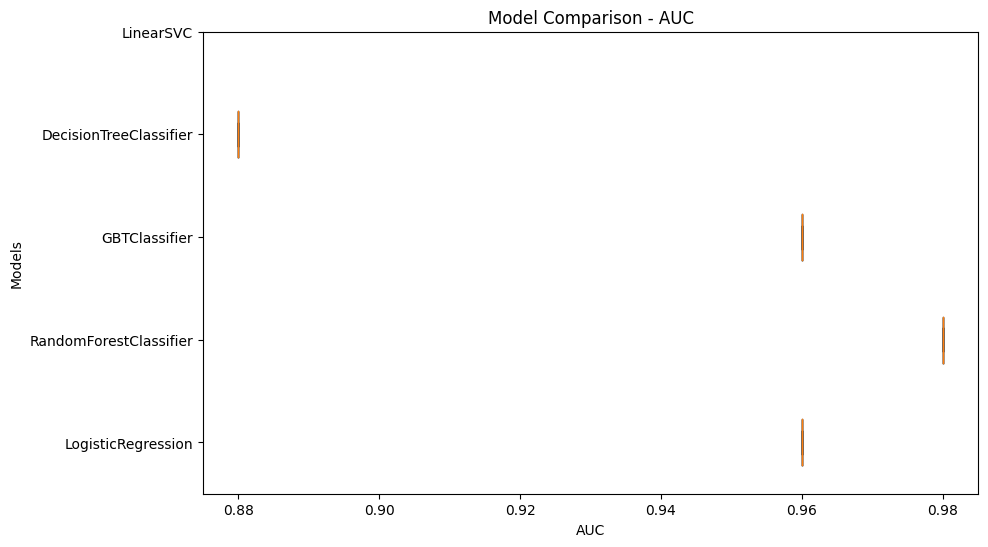

Generating plot for Precision (Non-Fraud)...
Sorted model data for Precision (Non-Fraud): [[0.5], [0.5], [0.5], [0.5]]


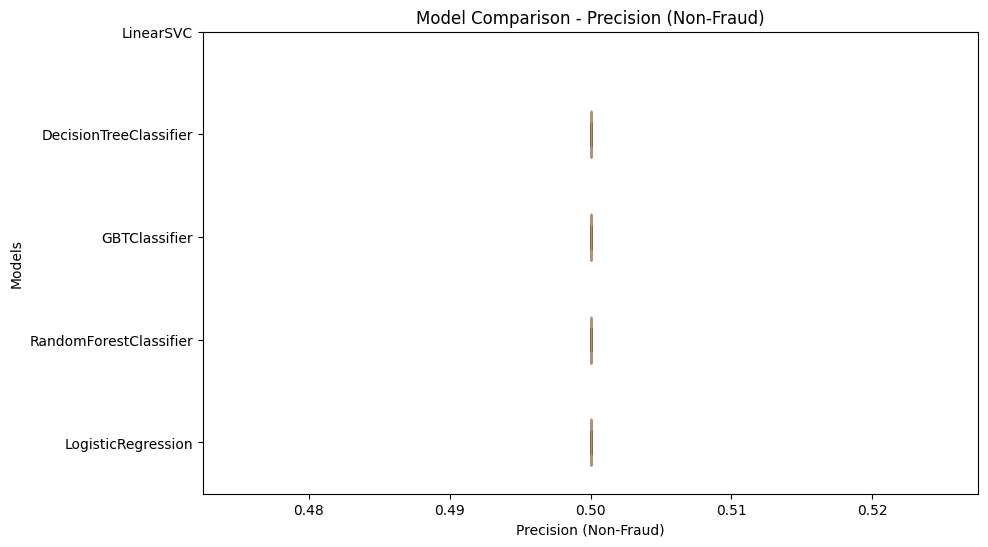

Generating plot for Precision (Fraud)...
Sorted model data for Precision (Fraud): [[0.51], [0.51], [0.51], [0.49]]


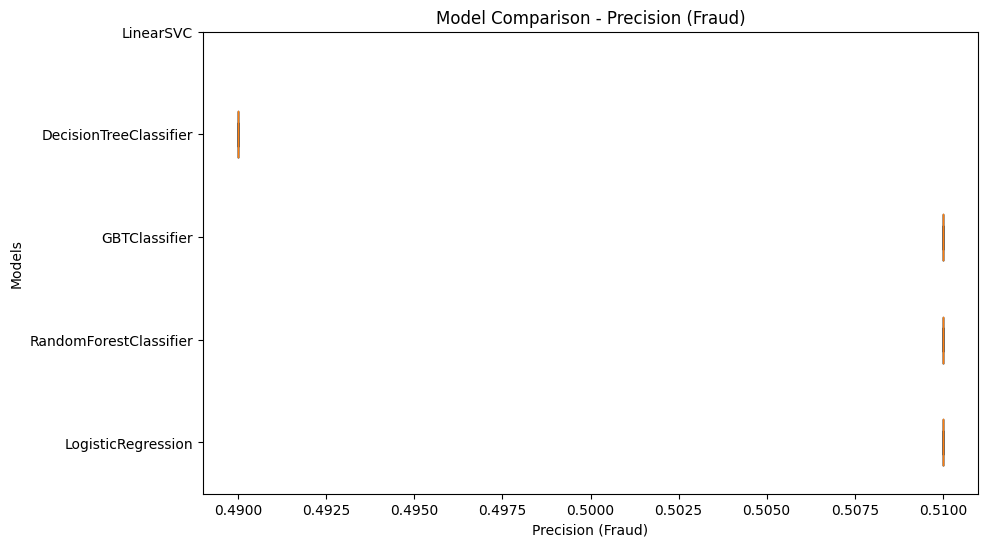

Generating plot for Recall (Non-Fraud)...
Sorted model data for Recall (Non-Fraud): [[1.0], [1.0], [1.0], [1.0]]


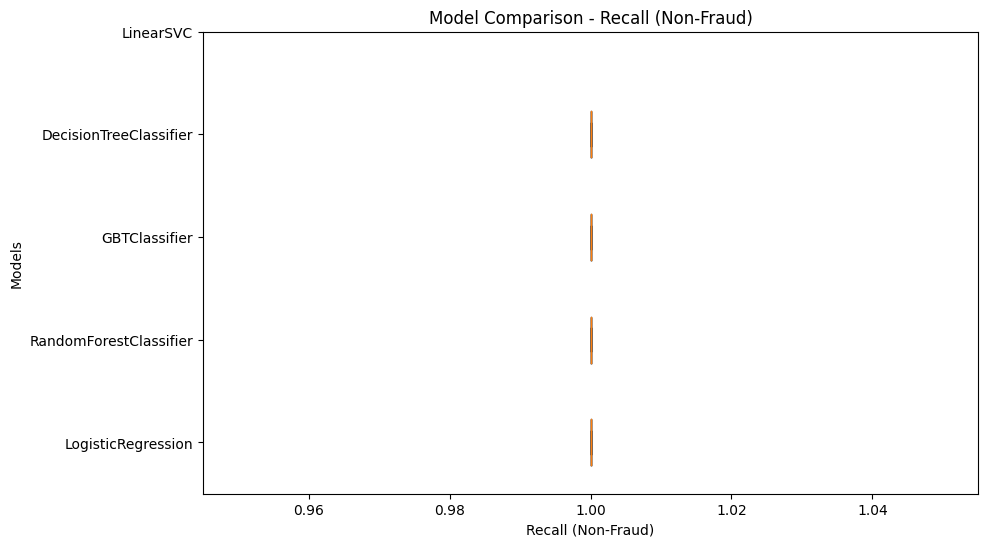

Generating plot for Recall (Fraud)...
Sorted model data for Recall (Fraud): [[1.0], [1.0], [1.0], [0.96]]


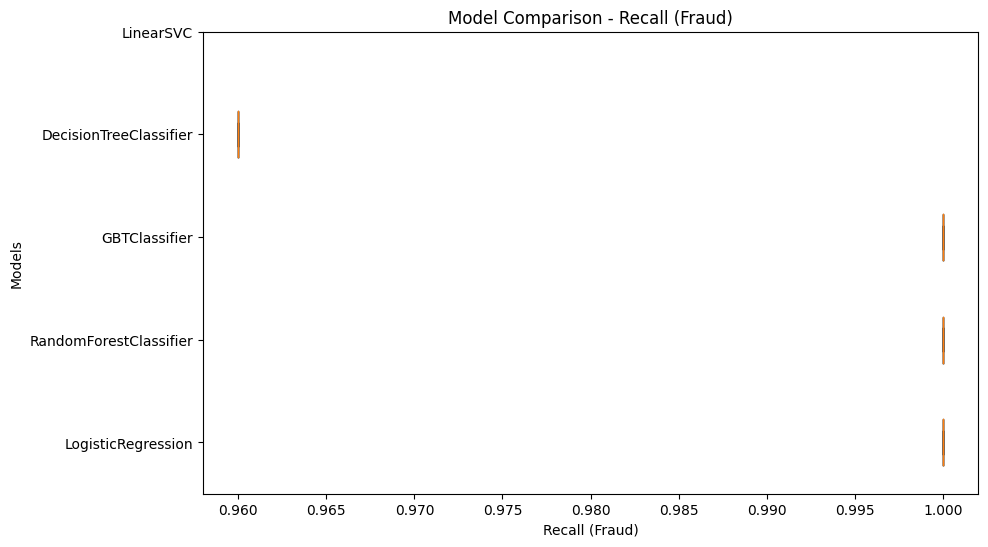

Generating plot for F1-score (Non-Fraud)...
Sorted model data for F1-score (Non-Fraud): [[0.89], [0.94], [0.92], [0.89]]


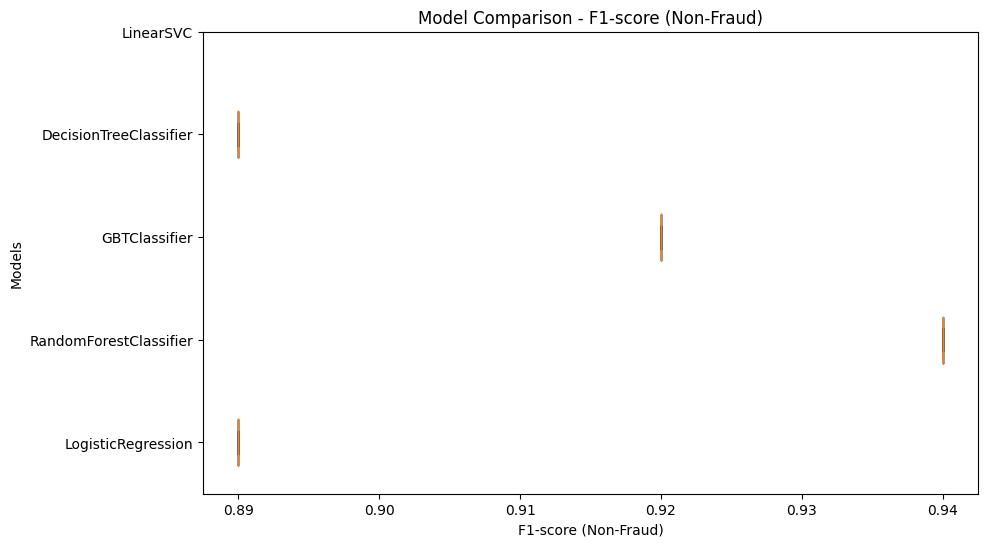

Generating plot for F1-score (Fraud)...
Sorted model data for F1-score (Fraud): [[0.9], [0.94], [0.91], [0.89]]


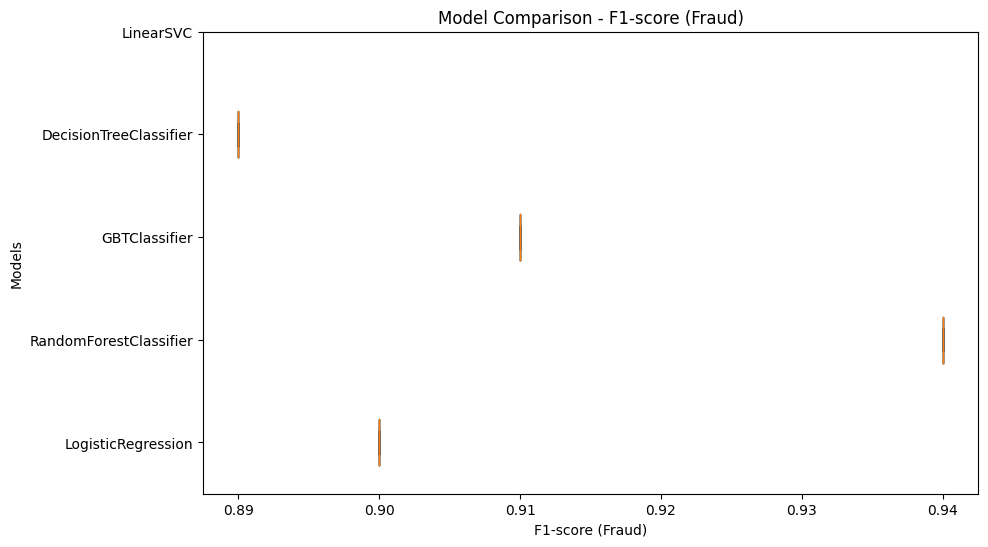

Generating plot for Log Loss...
Sorted model data for Log Loss: [[0.37], [0.17], [0.26], [1.59]]


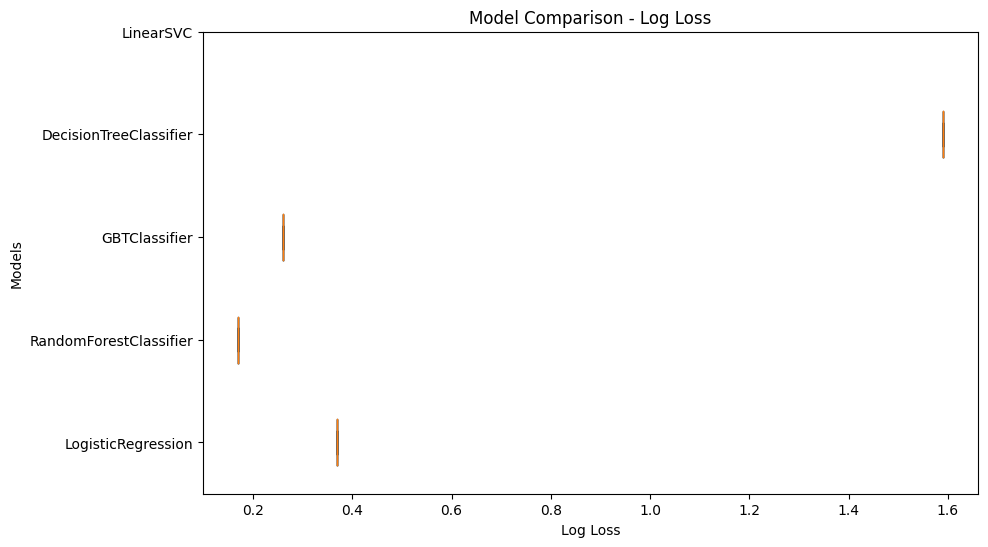

Generating plot for Mean Squared Error...
Sorted model data for Mean Squared Error: [[0.12], [0.05], [0.07], [0.09]]


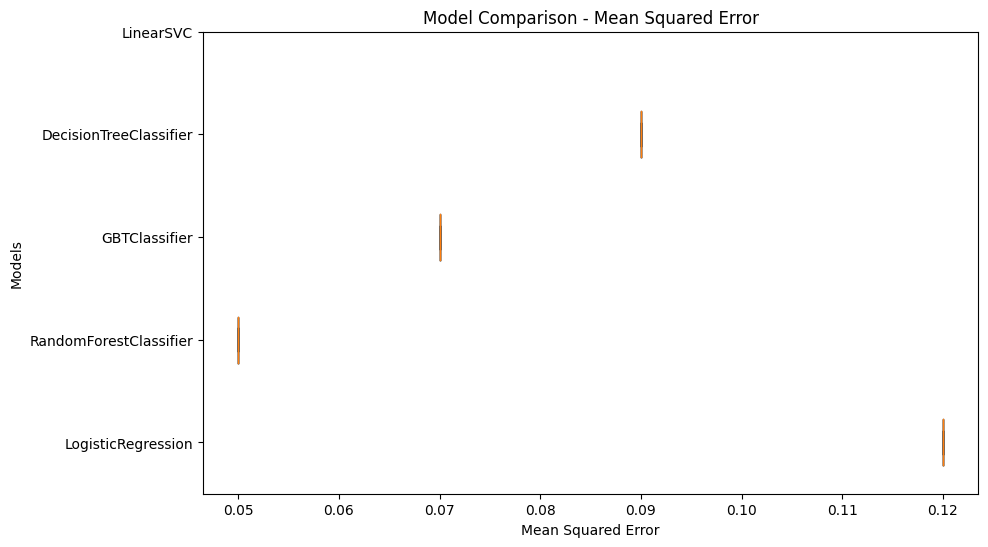

Generating plot for Mean Absolute Error...
Sorted model data for Mean Absolute Error: [[0.28], [0.11], [0.16], [0.12]]


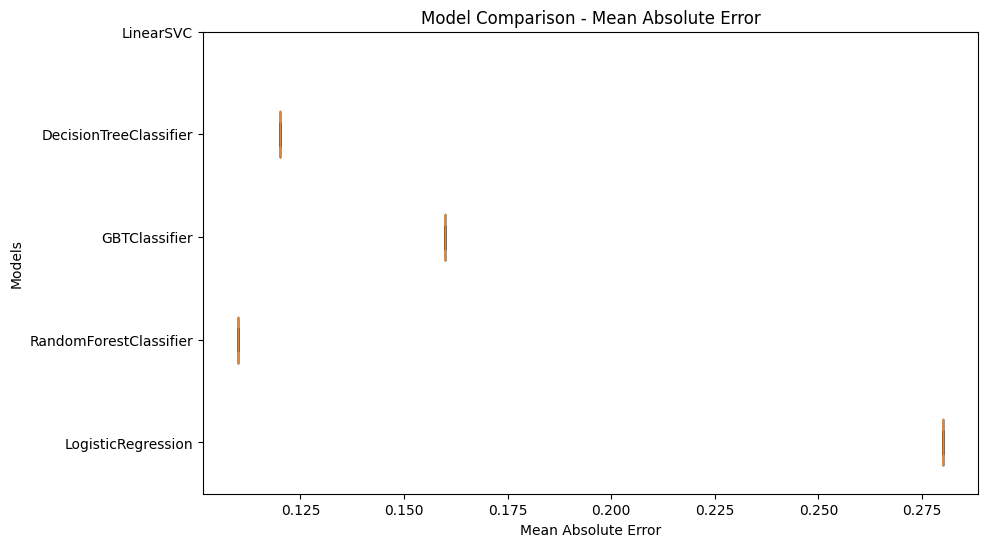

Generating plot for Matthews Correlation Coefficient...
Sorted model data for Matthews Correlation Coefficient: [[0.79], [0.88], [0.83], [0.79]]


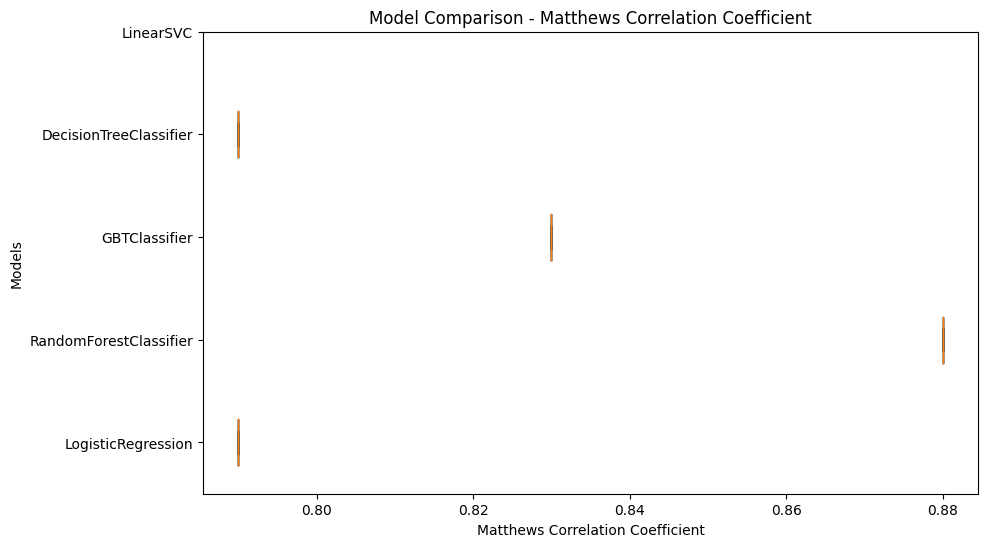

Generating plot for Cohen's Kappa...
Sorted model data for Cohen's Kappa: [[0.79], [0.88], [0.83], [0.79]]


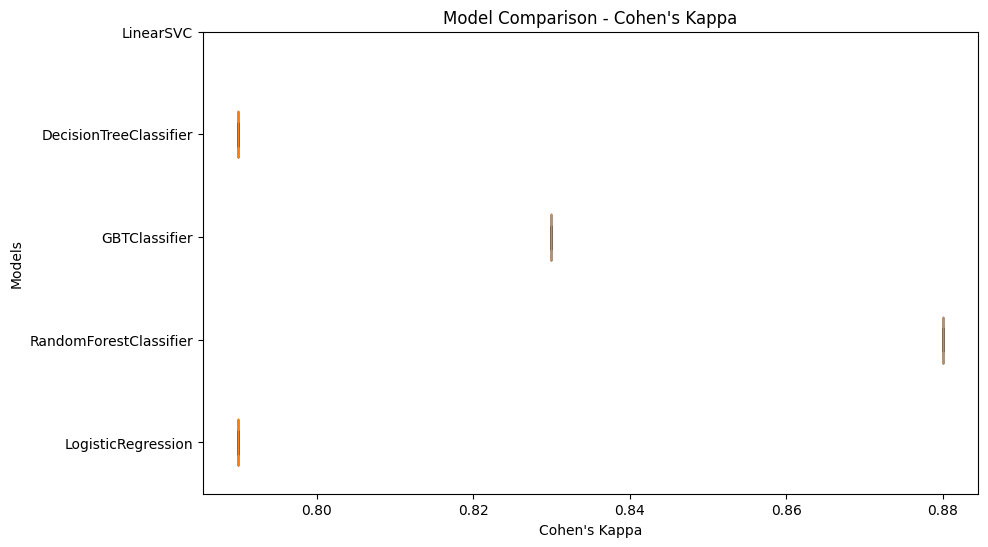

In [47]:
def plot_model_boxplot_comparison(models_metrics):
    models = list(models_metrics.keys())
    metrics = list(models_metrics[models[0]].keys())

    excluded_metrics = ['fpr', 'tpr', 'roc_auc', 'Confusion Matrix']

    print("Models:", models)
    print("Metrics:", metrics)

    for metric in metrics:
        if metric in excluded_metrics:
            continue

        print(f"Generating plot for {metric}...")
        model_data = []

        # Collect the data for each model
        for model in models:
            model_metrics = models_metrics[model]
            metric_value = model_metrics.get(metric)
            if metric_value is not None:
                # Ensure metric value is a list
                if not isinstance(metric_value, list):
                    metric_value = [metric_value]
                model_data.append(metric_value)

        print(f"Sorted model data for {metric}: {model_data}")

        # Check if there's any data to plot
        if model_data:
            plt.figure(figsize=(10, 6))  # Create a new figure for each metric
            plt.boxplot(model_data, vert=False)  # Plot boxplots horizontally
            plt.yticks(range(1, len(models) + 1), models)  # Set y-axis labels to model names
            plt.xlabel(metric)
            plt.ylabel('Models')
            plt.title(f'Model Comparison - {metric}')
            plt.show()

# Example usage:
plot_model_boxplot_comparison(models_metrics)



# Horizontal bar plots of the performance metrics

Models: ['LogisticRegression', 'RandomForestClassifier', 'GBTClassifier', 'DecisionTreeClassifier']
Metrics: ['Accuracy', 'AUC', 'Precision (Non-Fraud)', 'Precision (Fraud)', 'Recall (Non-Fraud)', 'Recall (Fraud)', 'F1-score (Non-Fraud)', 'F1-score (Fraud)', 'Log Loss', 'Mean Squared Error', 'Mean Absolute Error', 'Matthews Correlation Coefficient', "Cohen's Kappa"]


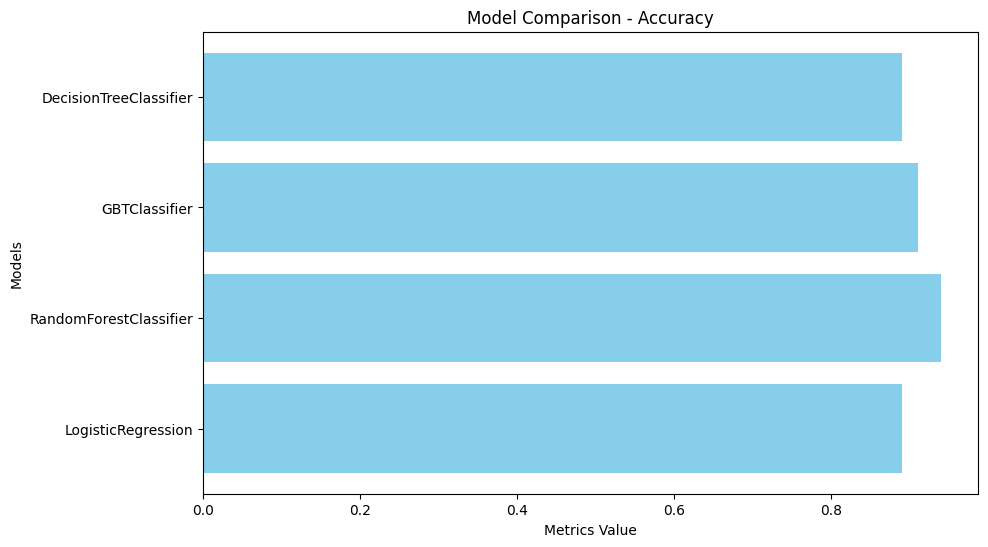

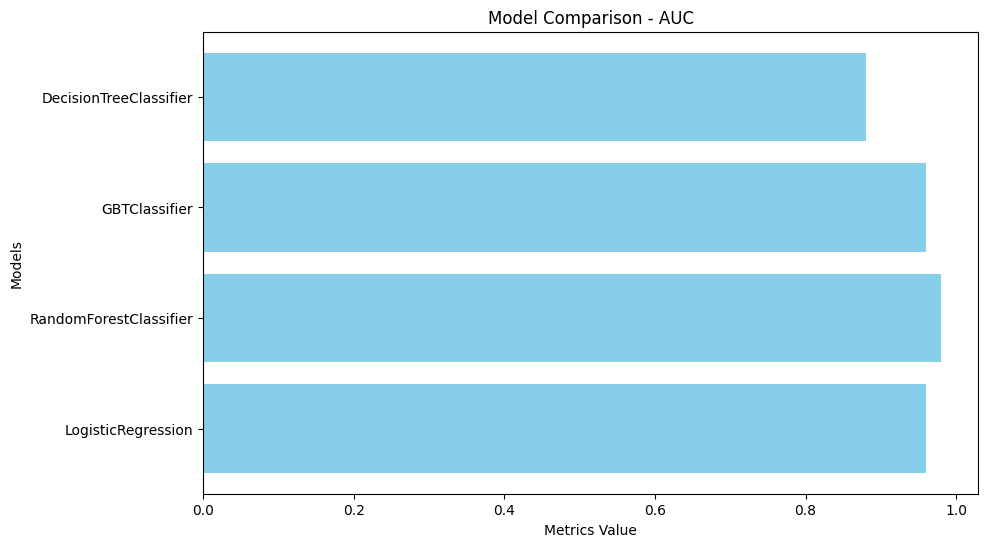

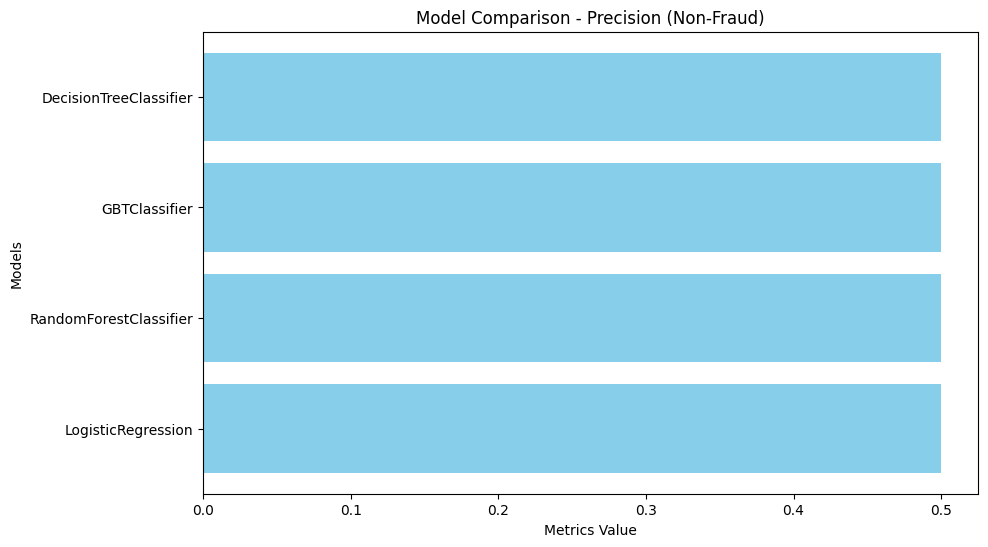

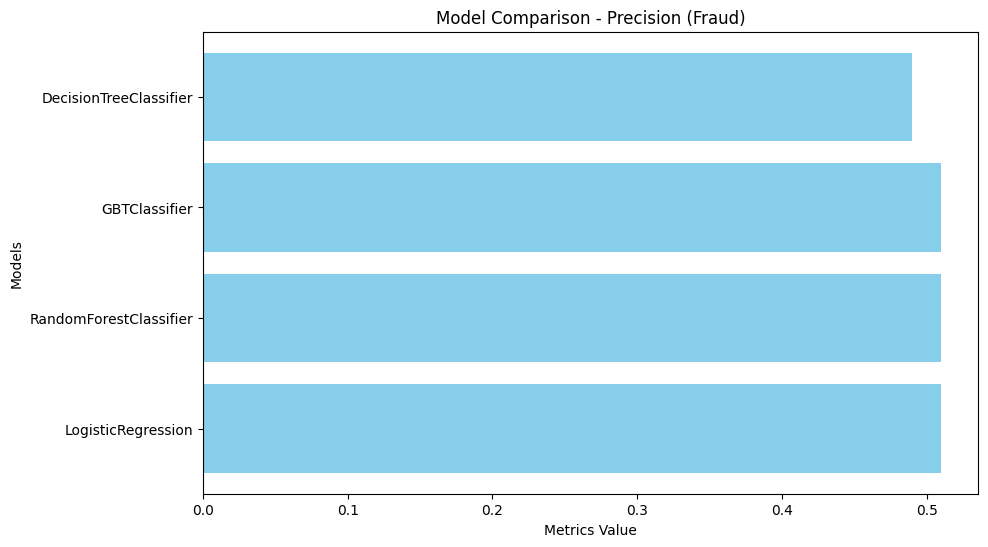

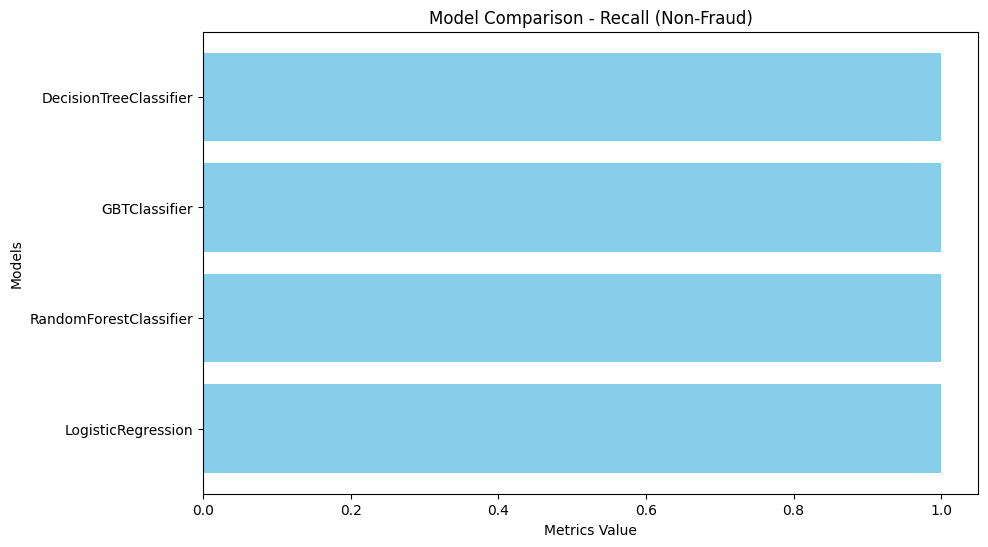

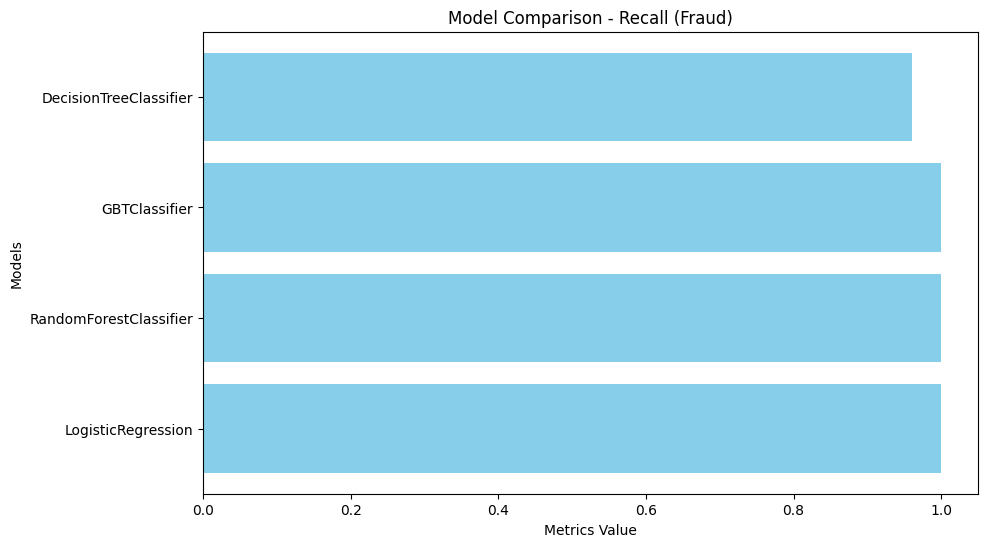

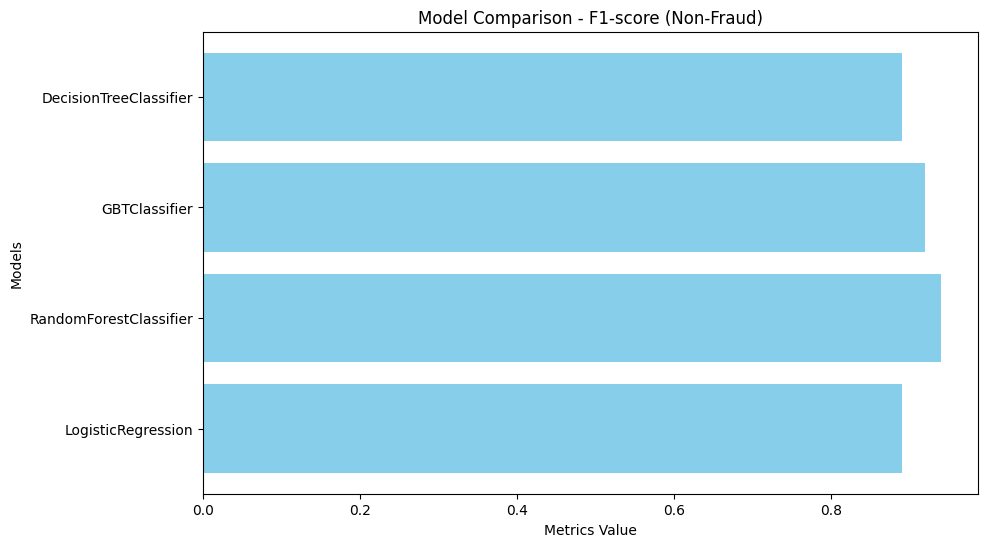

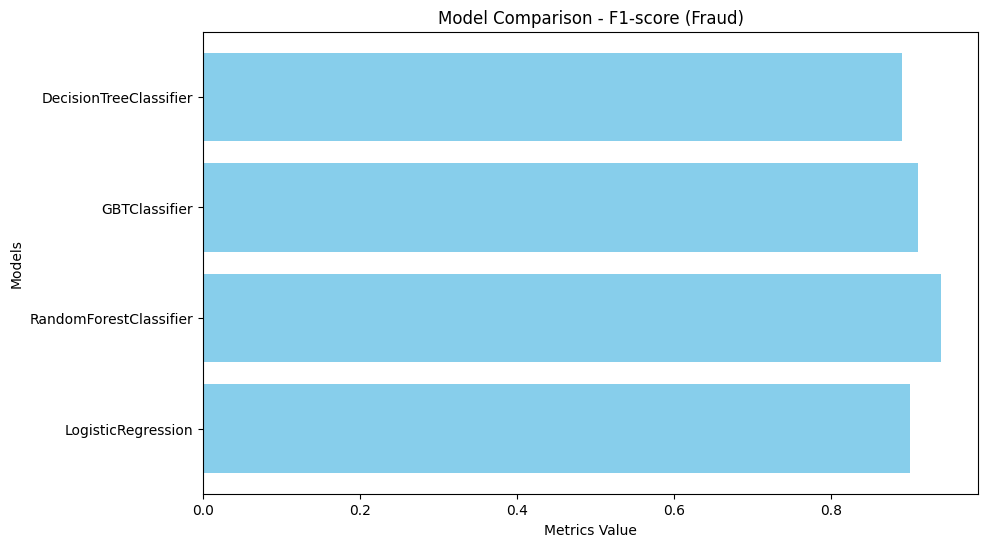

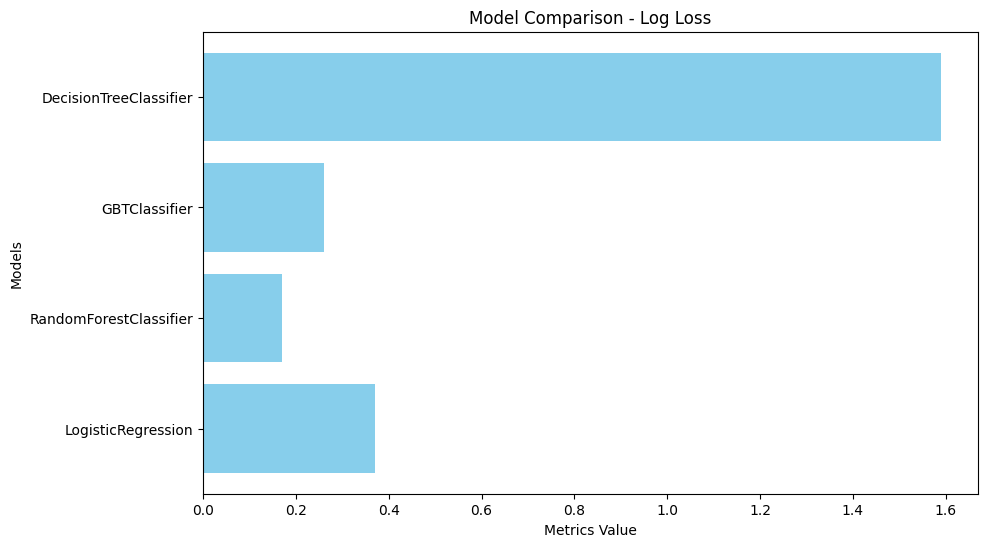

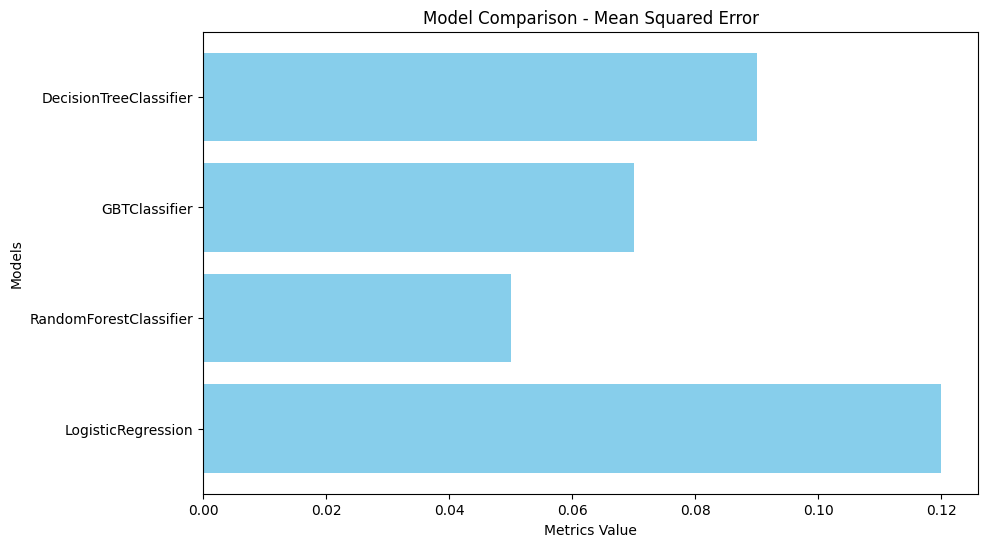

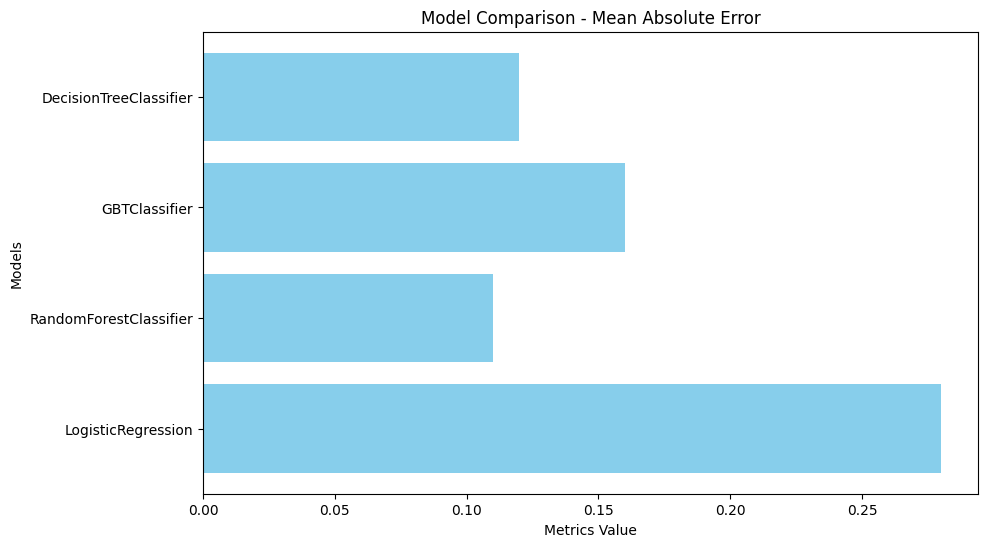

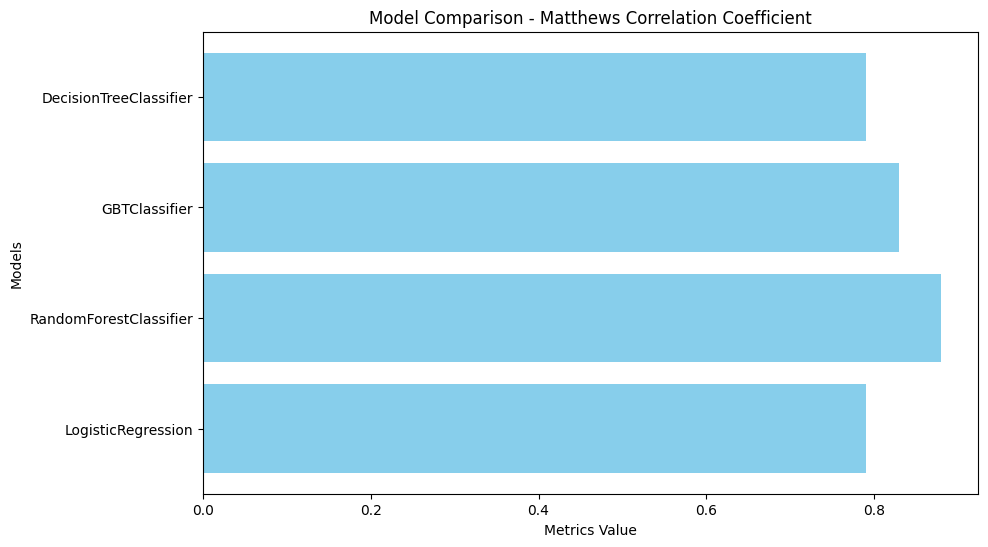

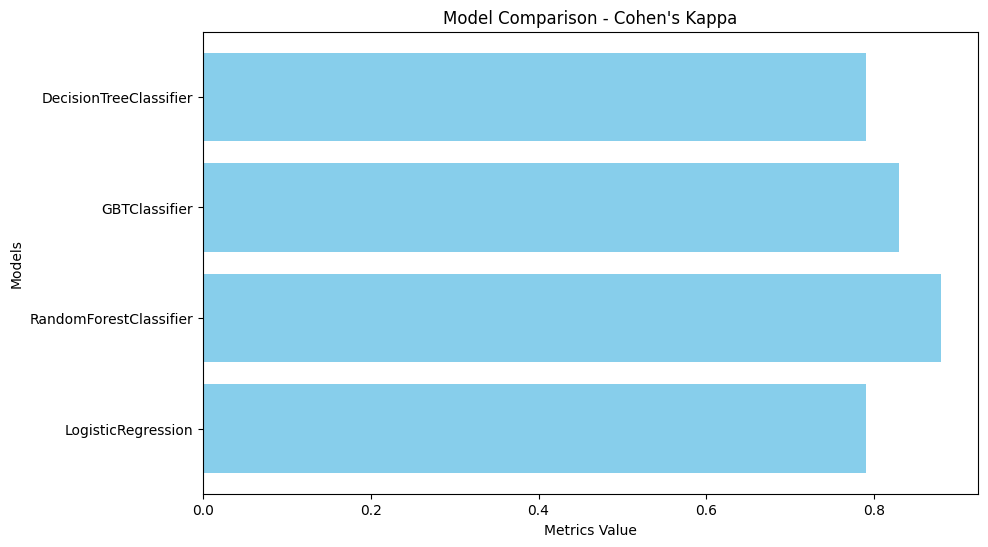

In [50]:
def plot_model_comparison(models_metrics):
    models = ['LogisticRegression', 'RandomForestClassifier', 'GBTClassifier', 'DecisionTreeClassifier']
    metrics = ['Accuracy', 'AUC', 'Precision (Non-Fraud)', 'Precision (Fraud)', 'Recall (Non-Fraud)',
               'Recall (Fraud)', 'F1-score (Non-Fraud)', 'F1-score (Fraud)', 'Log Loss', 'Mean Squared Error',
               'Mean Absolute Error', 'Matthews Correlation Coefficient', "Cohen's Kappa"]

    print("Models:", models)
    print("Metrics:", metrics)

    for metric in metrics:
        plt.figure(figsize=(10, 6))  # Create a new figure for each metric
        model_data = []

        # Collect the data for each model
        for model in models:
            if model in models_metrics:
                metric_values = models_metrics[model].get(metric)
                if metric_values is not None:  # Check if metric value is not None
                    model_data.append(metric_values)

        # Check if there's any data to plot
        if model_data:
            # Plot the horizontal bar plot
            plt.barh(models, model_data, color='skyblue')

            plt.xlabel('Metrics Value')
            plt.ylabel('Models')
            plt.title(f'Model Comparison - {metric}')
            plt.show()
        else:
            print(f"No data found for any model and metric {metric}")

# Example usage:
plot_model_comparison(models_metrics)


# Plotting ROC and ROC_AUC plots of the hypertuned models

In [42]:
def plot_roc_curve(models_metrics, classifier_names):
    plt.figure(figsize=(8, 6))
    for model_name in classifier_names:
        metrics = models_metrics.get(model_name, {})
        if "fpr" in metrics and "tpr" in metrics:
            fpr, tpr = metrics["fpr"], metrics["tpr"]
            roc_auc = metrics.get("roc_auc", None)
            label = f'{model_name} (AUC = {roc_auc:.2f})' if roc_auc is not None else model_name
            plt.plot(fpr, tpr, label=label)

    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    if any("roc_auc" in metrics for metrics in models_metrics.values()):  # Check if any model has ROC-AUC information
        plt.legend()
    plt.show()

def plot_roc_auc_curve(models_metrics, classifier_names):
    plt.figure(figsize=(8, 6))
    for model_name in classifier_names:
        metrics = models_metrics.get(model_name, {})
        if "fpr" in metrics and "tpr" in metrics:
            fpr, tpr = metrics["fpr"], metrics["tpr"]
            roc_auc = metrics.get("roc_auc", None)
            label = f'{model_name} (AUC = {roc_auc:.2f})' if roc_auc is not None else model_name
            plt.plot(fpr, tpr, label=label)

    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC-AUC Curve')
    if any("roc_auc" in metrics for metrics in models_metrics.values()):  # Check if any model has ROC-AUC information
        plt.legend()
    plt.show()



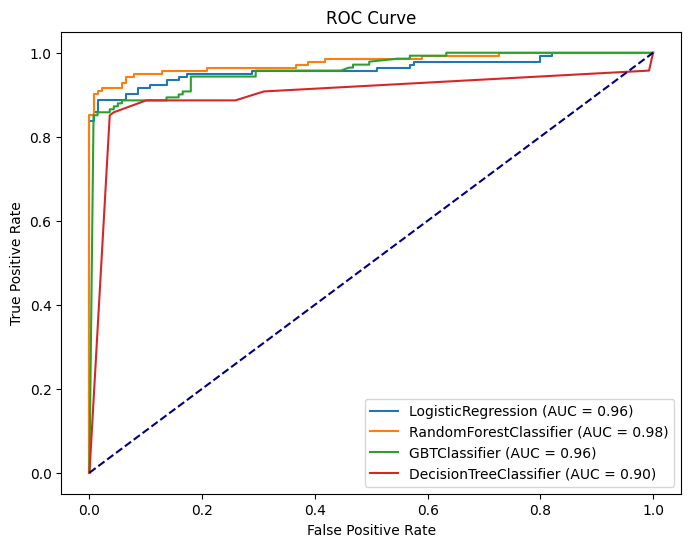

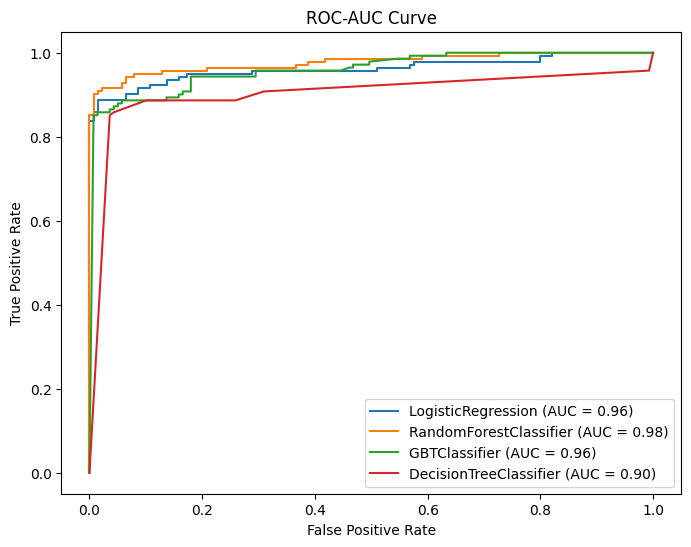

In [43]:
# Plot ROC curves
plot_roc_curve({model_name: metrics for model_name, metrics in models_metrics.items() if "fpr" in metrics}, classifier_names)

# Plot ROC-AUC curves
plot_roc_auc_curve({model_name: metrics for model_name, metrics in models_metrics.items() if "fpr" in metrics}, classifier_names)


# Things to complete

* make these classifiers to work
** XGBClassifier,
** LGBMClassifier
** CatBoostClassifier,
** XGBClassifier


# Finding the best performing model based on the performance metrics analyzed

  That is, which model has the highest rating amongst the performance metrics analyzed? (highest overall score or lowest overall score) depending on the performance metric

  These three performance metrics checks on the lowest scres
  * Log Loss
  * Mean Square Error (MSE)
  * Mean Absolute Error (MAE)

  The rest checks on the highest score

In [52]:
# Initialize dictionaries to store the scores
metric_max_scores = {}
metric_min_scores = {}

# Initialize variables to store the models with highest and lowest scores for respective metrics
metric_max_models = {}
metric_min_models = {}

# Define the metrics we are interested in
metrics_to_maximize = ['roc_auc', 'AUC', 'Precision (Non-Fraud)', 'Precision (Fraud)', 'Recall (Non-Fraud)',
               'Recall (Fraud)', 'F1-score (Non-Fraud)', 'F1-score (Fraud)', "Cohen's Kappa", "Matthews Correlation Coefficient"]
metrics_to_minimize = ['Log Loss', 'Mean Squared Error', 'Mean Absolute Error']


# Find the models with the highest scores for each metric
for metric in metrics_to_maximize:
    max_score = float('-inf')
    max_model = None
    for model_name, model_metric in models_metrics.items():
        if metric in model_metric:
            if model_metric[metric] > max_score:
                max_score = model_metric[metric]
                max_model = model_name
    metric_max_scores[metric] = max_score
    metric_max_models[metric] = max_model

# Find the models with the lowest scores for each metric
for metric in metrics_to_minimize:
    min_score = float('inf')
    min_model = None
    for model_name, model_metric in models_metrics.items():
        if metric in model_metric:
            if model_metric[metric] < min_score:
                min_score = model_metric[metric]
                min_model = model_name
    metric_min_scores[metric] = min_score
    metric_min_models[metric] = min_model

# Print the models with the highest scores for each metric
print("Models with highest scores:")
for metric, model in metric_max_models.items():
    print(f"{metric}: {model} - Score: {metric_max_scores[metric]}")

# Print the models with the lowest scores for each metric
print("\nModels with lowest scores:")
for metric, model in metric_min_models.items():
    print(f"{metric}: {model} - Score: {metric_min_scores[metric]}")


Models with highest scores:
roc_auc: RandomForestClassifier - Score: 0.9770396448798407
AUC: RandomForestClassifier - Score: 0.98
Precision (Non-Fraud): LogisticRegression - Score: 0.5
Precision (Fraud): LogisticRegression - Score: 0.51
Recall (Non-Fraud): LogisticRegression - Score: 1.0
Recall (Fraud): LogisticRegression - Score: 1.0
F1-score (Non-Fraud): RandomForestClassifier - Score: 0.94
F1-score (Fraud): RandomForestClassifier - Score: 0.94
Cohen's Kappa: RandomForestClassifier - Score: 0.88
Matthews Correlation Coefficient: RandomForestClassifier - Score: 0.88

Models with lowest scores:
Log Loss: RandomForestClassifier - Score: 0.17
Mean Squared Error: RandomForestClassifier - Score: 0.05
Mean Absolute Error: RandomForestClassifier - Score: 0.11


# Overall Random Forest Classifier is the best model for the credit card fraud detection followed by logistic regression